## Optimizing Dry Bean Sorting into Classes using Classification with K-nearest neighbors

In agriculture, sorting seeds based on physical characteristics like size and shape is critical in post-harvest processing. However, manual sorting is time-consuming and costly, and its accuracy can vary by individual. As a result, there is growing interest in automatic sorting systems. Computer algorithms are used to analyze images of seeds and classify seeds based on features like size and shape, making sorting faster, more accurate, and less labor-intensive than manual sorting.

Our project focuses on analyzing a dataset of digitized dry bean image features created by Koklu, M. and Ozakan, I.A. (Koklu and Ozakan, 2020). The data has 17 attributes and 13611 observations. Each row in the dataset corresponds to an image of a dry bean and includes information about its Class (target) and other measurements including perimeter, roundness, (predictors), etc. We will be using K-nearest classification to predict the Class of seeds using selected predictors out of the 16.

#### Research Question: Is it possible to utilize the measurements of existing dry bean images to accurately predict the Class of an unclassified bean image?

Variables of interest (after primilinary analysis): 

Perimeter (P): Bean circumference is defined as the length of its border.

perpendicular to the main axis.

Aspect ratio (K): Defines the relationship between L and l.

Eccentricity (Ec): Eccentricity of the ellipse having the same moments as the region.

Convex area (C): Number of pixels in the smallest convex polygon that can contain the area of a bean seed.

Equivalent diameter (Ed): The diameter of a circle having the same area as a bean seed area.

Roundness (R): Calculated with the following formula: (4piA)/(P^2)

Compactness (CO): Measures the roundness of an object: Ed/L

In [1]:
# Download all the necessay libraries
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("tableone")
library(tableone)
options(repr.matrix.max.rows = 6)



── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:

# Read dataset

url <- "https://github.com/NaziaNadir/dsci-100-2023-007-group-8/raw/main/Dry_Bean_Dataset.csv"
bean_data <- read_csv(url)

# remove missing values if any
bean_data <- filter(bean_data, rowSums(is.na(bean_data)) != ncol(bean_data))




Rows: 13611 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Class
dbl (16): Area, Perimeter, MajorAxisLength, MinorAxisLength, AspectRation, E...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Spliting the data into training and testing set

In [3]:

#Set the seed. Don't remove this!
set.seed(3456) 

# Randomly take 75% of the data in the training set. 
# This will be proportional to the different number of bean Classes in the dataset.

bean_split <- initial_split(bean_data, prop = 0.5, strata = Class)  
bean_train <- training(bean_split)   
bean_test <- testing(bean_split) # wont touch it until the best classifier is obtained

# your code here
bean_train
bean_test

Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
47794,833.459,279.6546,217.9186,1.283298,0.6267232,48528,246.6844,0.7381313,0.9848747,0.8645991,0.8821041,0.005851248,0.002185283,0.7781077,0.9985444,BARBUNYA
47981,809.088,291.6540,210.0432,1.388543,0.6937880,48451,247.1666,0.7697775,0.9902995,0.9210594,0.8474651,0.006078530,0.001934041,0.7181971,0.9972476,BARBUNYA
49317,886.931,310.5631,202.4589,1.533956,0.7582971,50400,250.5840,0.7130856,0.9785119,0.7878197,0.8068700,0.006297282,0.001646445,0.6510392,0.9986656,BARBUNYA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57790,920.668,360.9603,204.7025,1.763341,0.8236453,58342,271.2573,0.7359815,0.9905385,0.8567546,0.7514878,0.006246069,0.001228780,0.5647338,0.9958183,SIRA
57944,921.449,353.8206,210.4090,1.681585,0.8039647,59041,271.6185,0.6863532,0.9814197,0.8575821,0.7676727,0.006106252,0.001308154,0.5893215,0.9909941,SIRA
58074,910.115,351.9589,210.4178,1.672667,0.8016096,58609,271.9230,0.7776483,0.9908717,0.8810470,0.7725988,0.006060524,0.001332006,0.5969089,0.9984295,SIRA


Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
28395,610.291,208.1781,173.8887,1.197191,0.5498122,28715,190.1411,0.7639225,0.9888560,0.9580271,0.9133578,0.007331506,0.003147289,0.8342224,0.9987239,SEKER
28734,638.018,200.5248,182.7344,1.097356,0.4117853,29172,191.2728,0.7839681,0.9849856,0.8870336,0.9538608,0.006978659,0.003563624,0.9098505,0.9984303,SEKER
30279,634.927,212.5606,181.5102,1.171067,0.5204007,30600,196.3477,0.7756885,0.9895098,0.9438518,0.9237260,0.007020065,0.003152779,0.8532696,0.9992358,SEKER
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
42042,771.515,288.0827,186.3471,1.545947,0.7626149,42476,231.3645,0.8162544,0.9897825,0.8875738,0.8031185,0.006852259,0.001758458,0.6449992,0.9971345,DERMASON
42049,770.185,290.1634,185.0517,1.568013,0.7702435,42503,231.3838,0.7560050,0.9893184,0.8907902,0.7974258,0.006900602,0.001721186,0.6358878,0.9970802,DERMASON
42139,759.321,281.5399,191.1880,1.472582,0.7340648,42569,231.6313,0.7299324,0.9898988,0.9184241,0.8227297,0.006681220,0.001888271,0.6768842,0.9967673,DERMASON


In [4]:
# Finding the number of observations in each Class 
bean_count <- bean_train|>
                    group_by(Class)|>
                    summarize(count = n())|>
                    arrange(count)
bean_count


Class,count
<chr>,<int>
BOMBAY,266
BARBUNYA,648
CALI,814
⋮,⋮
SEKER,1012
SIRA,1339
DERMASON,1762


# Variable Selection



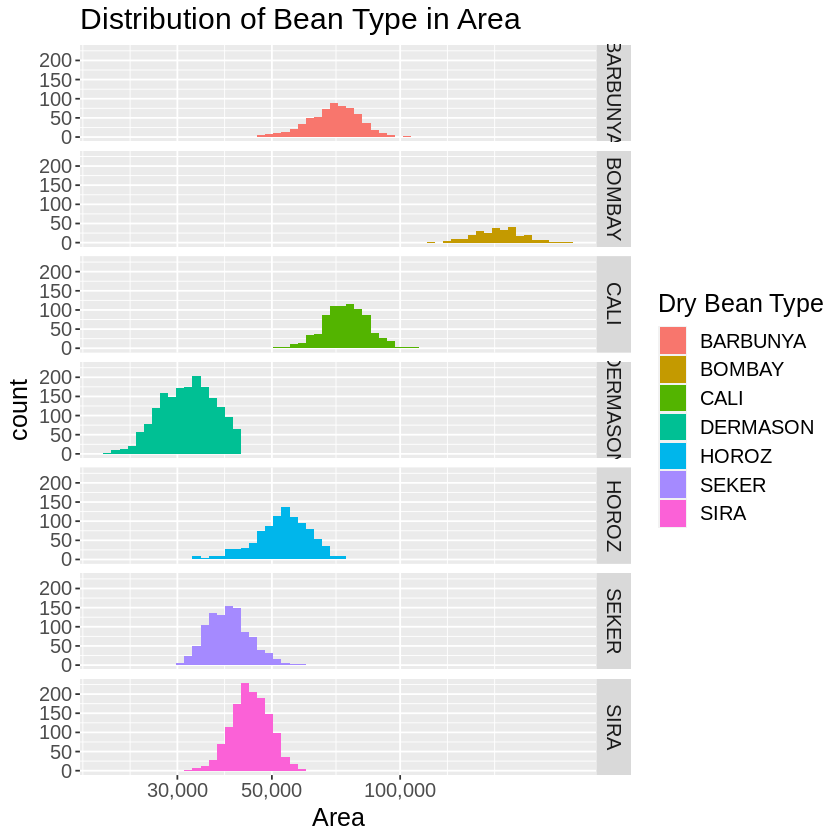

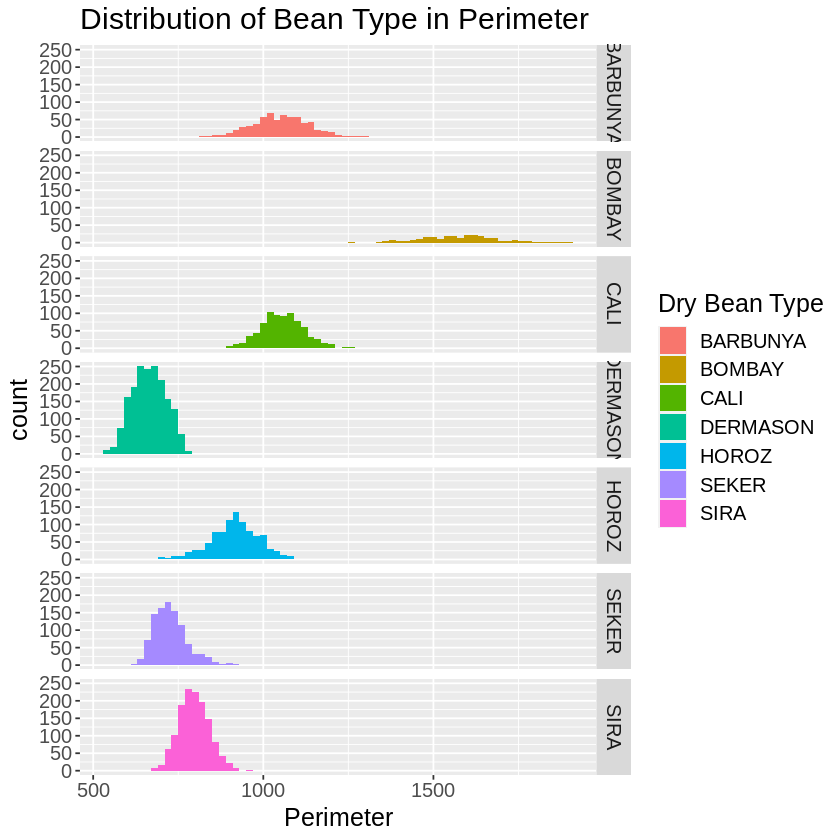

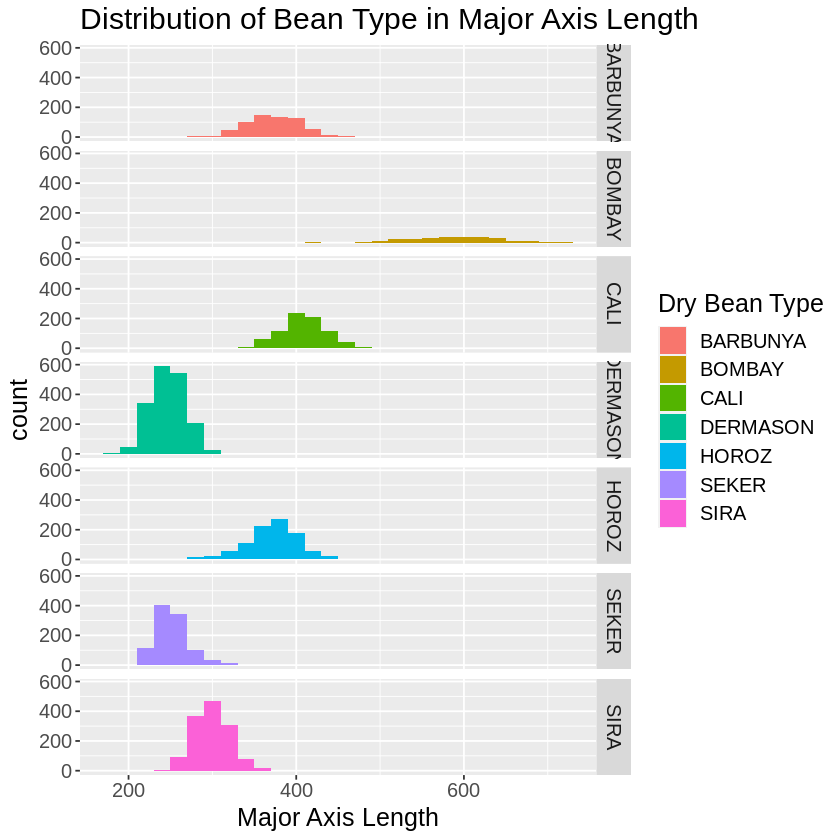

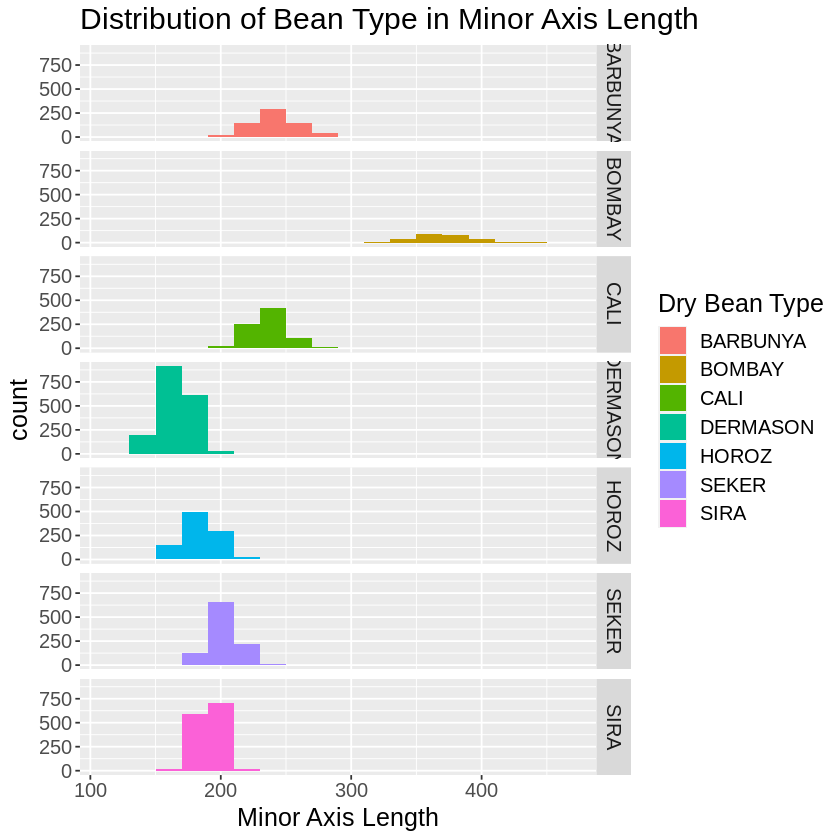

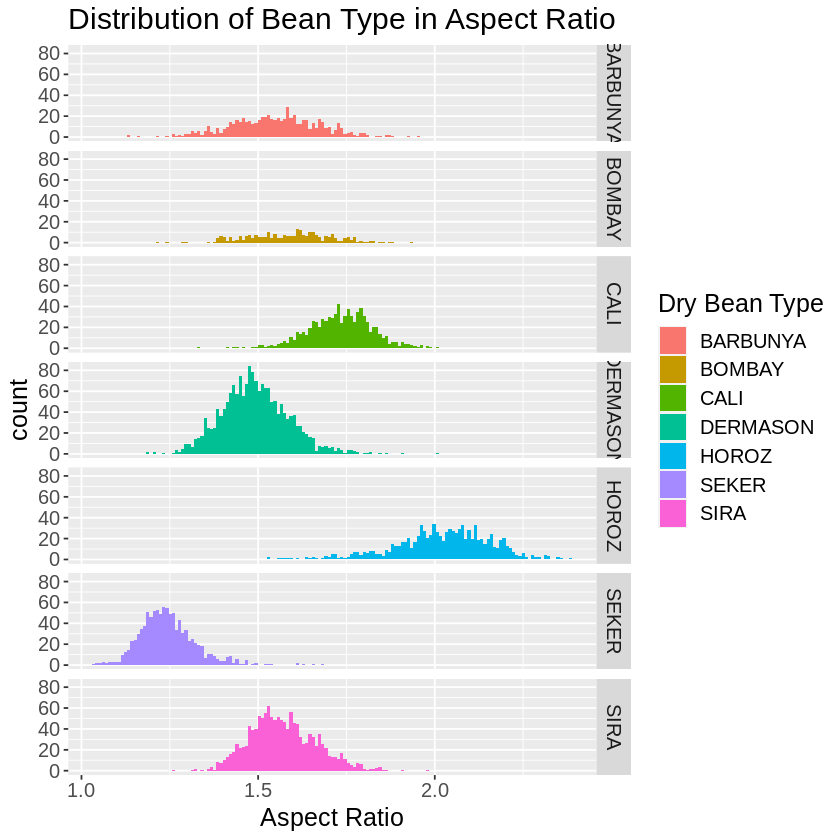

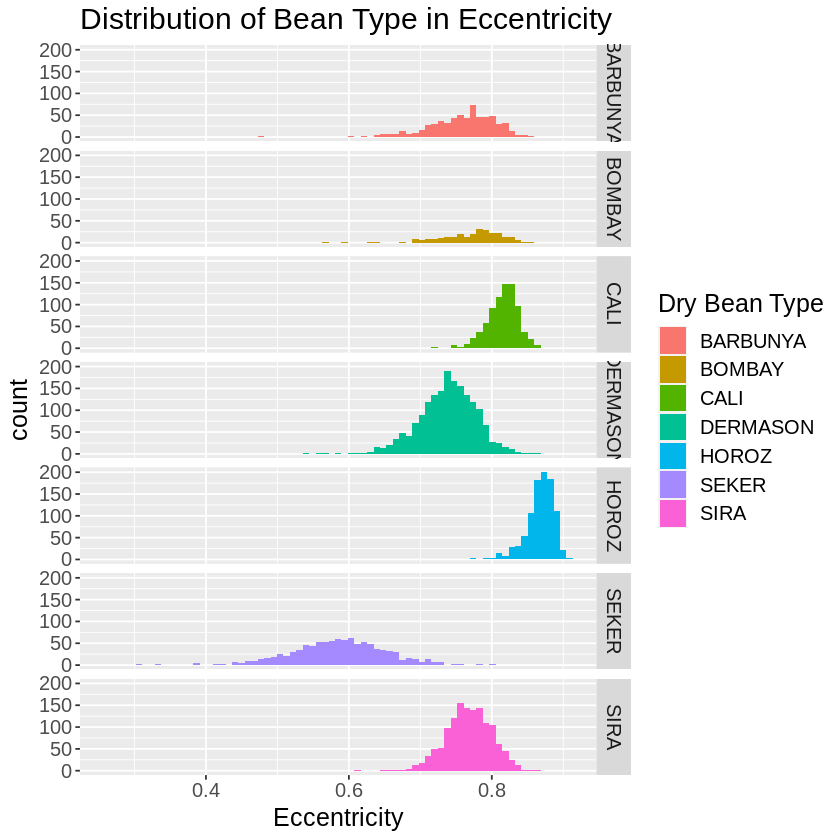

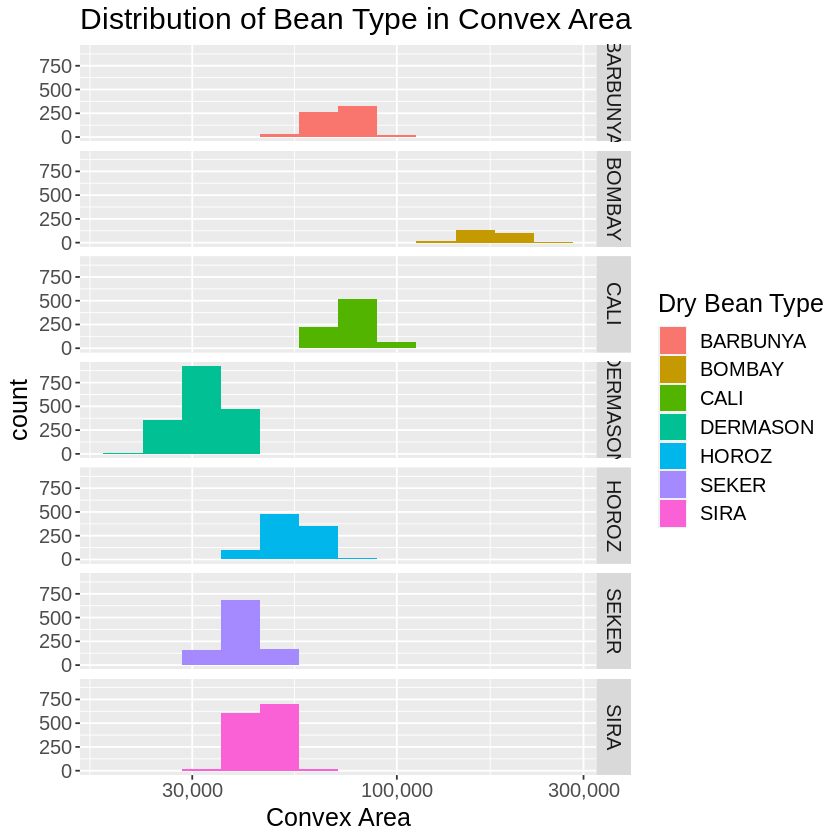

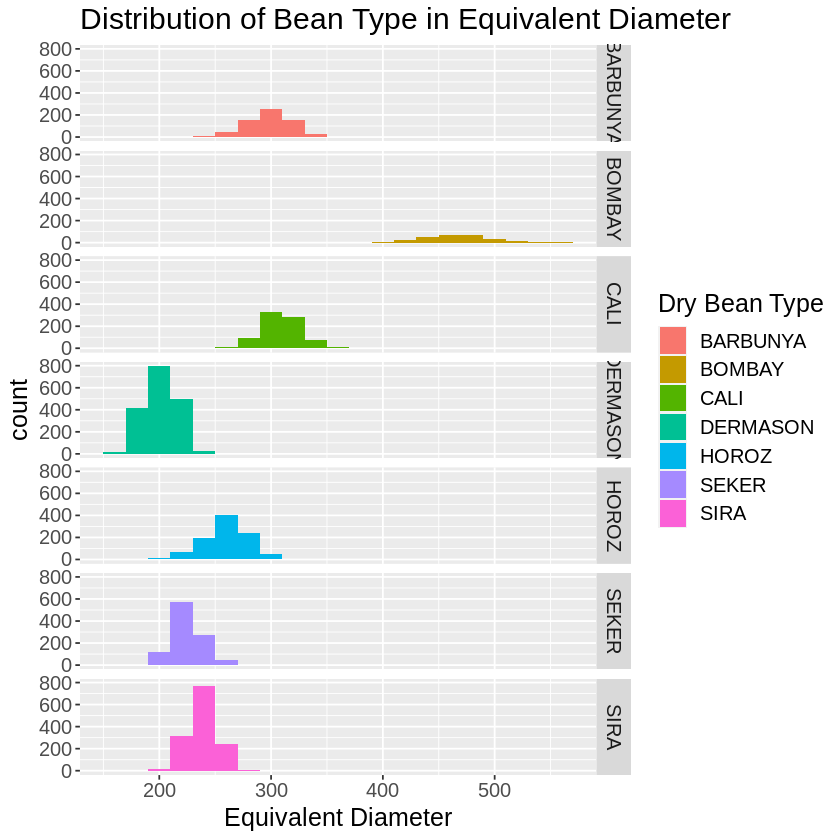

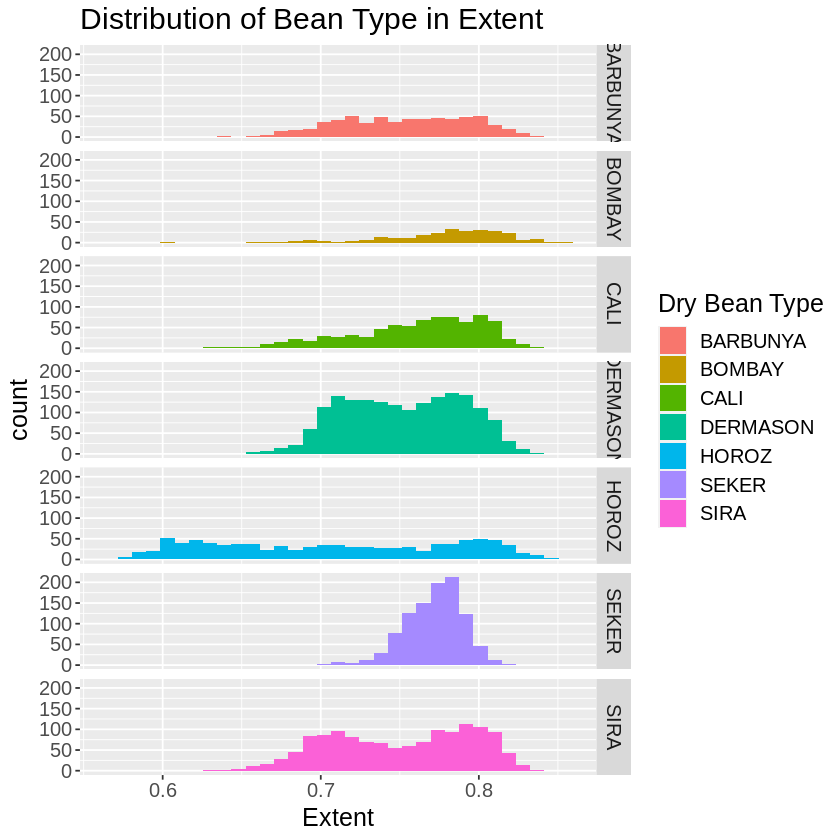

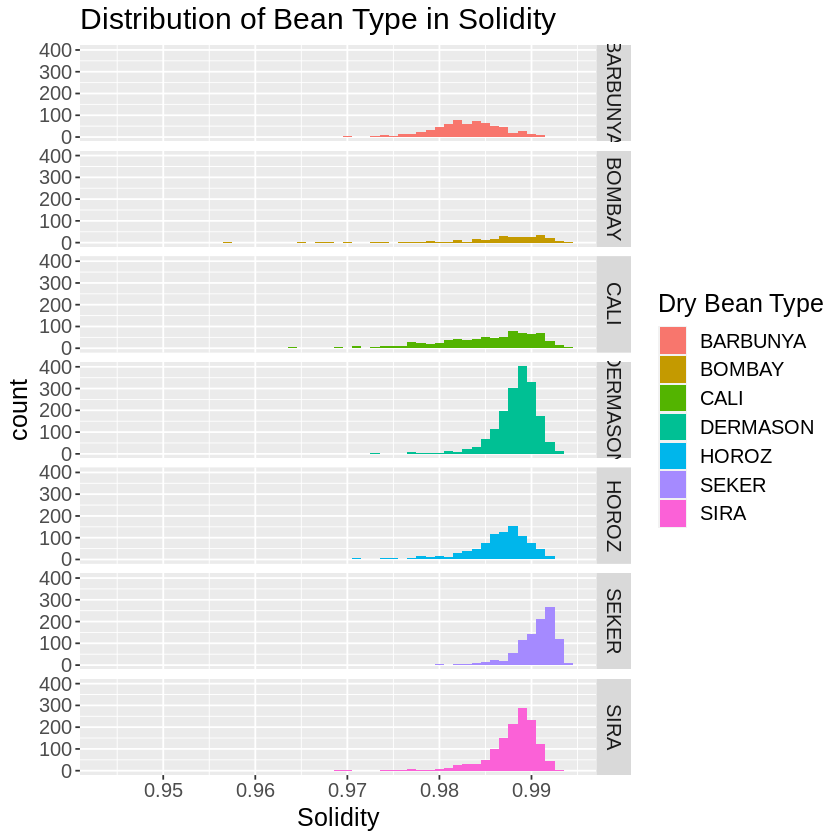

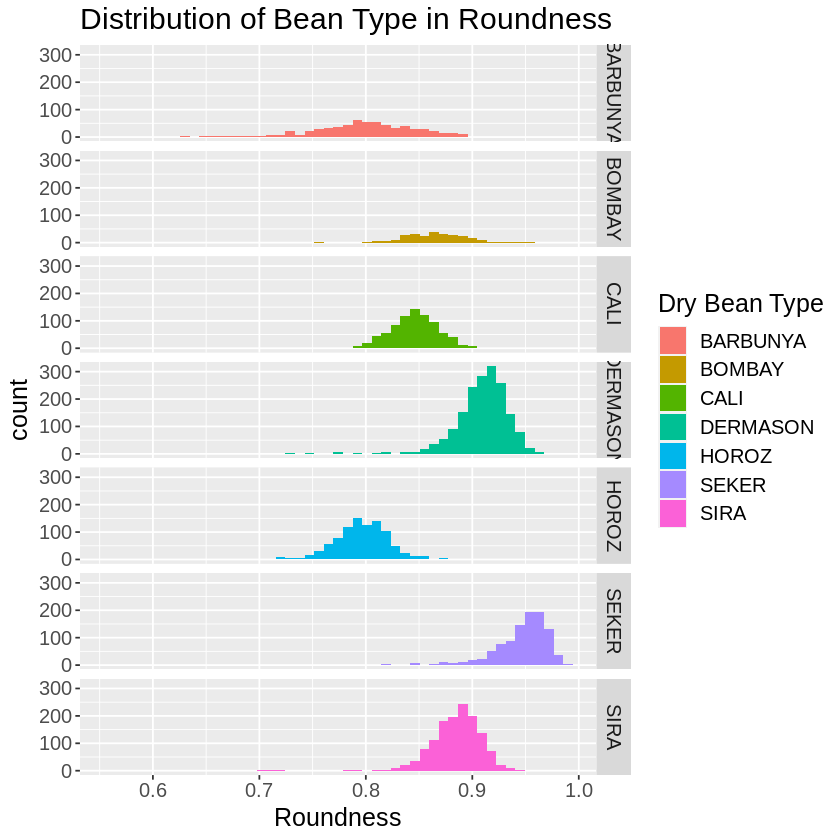

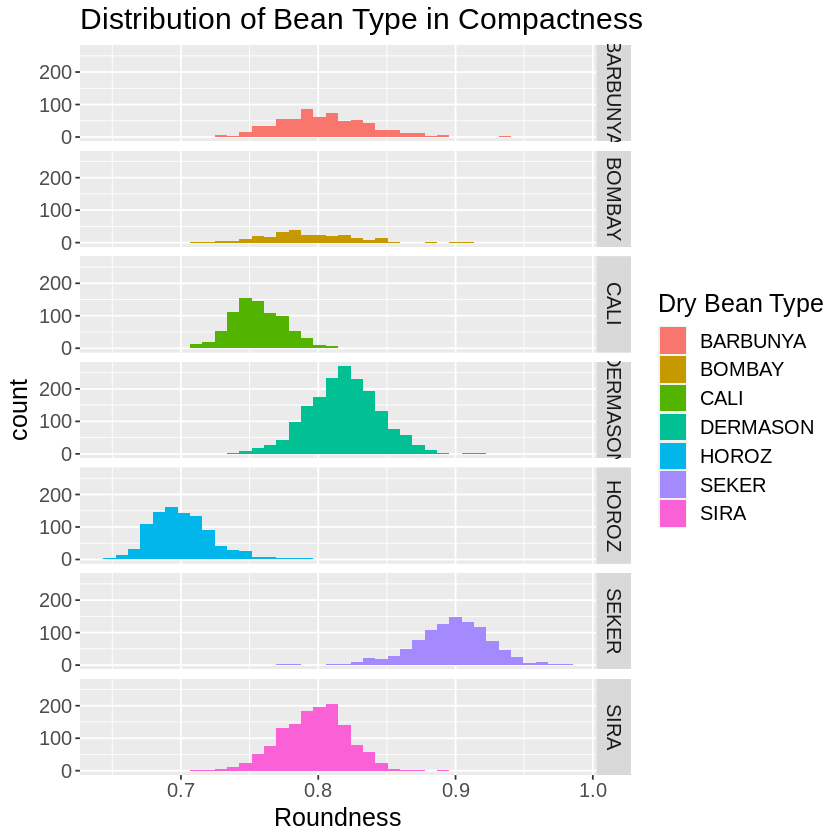

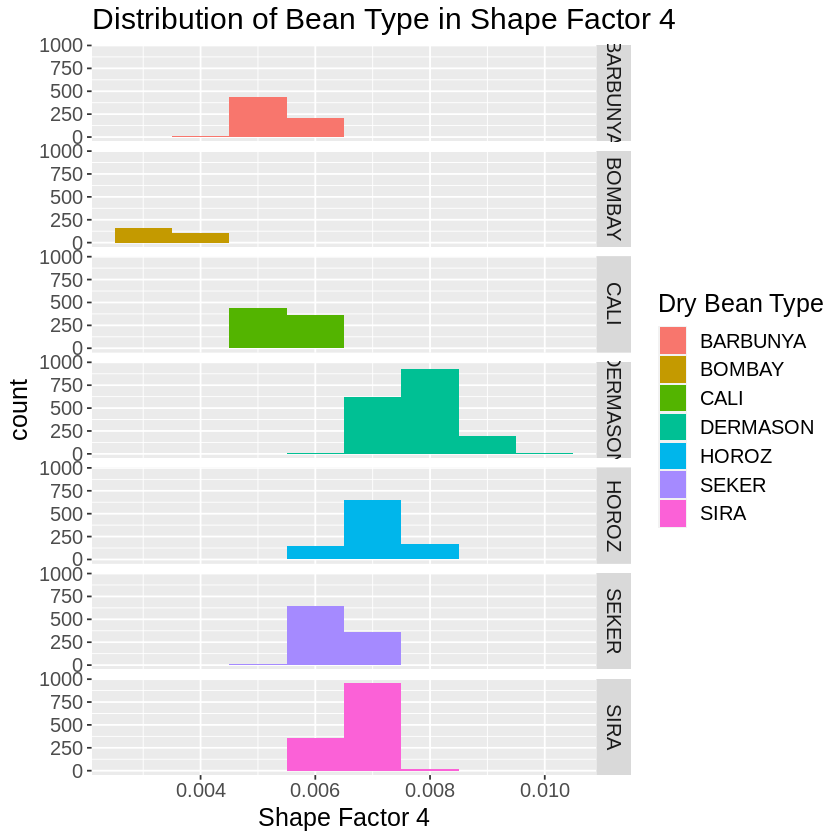

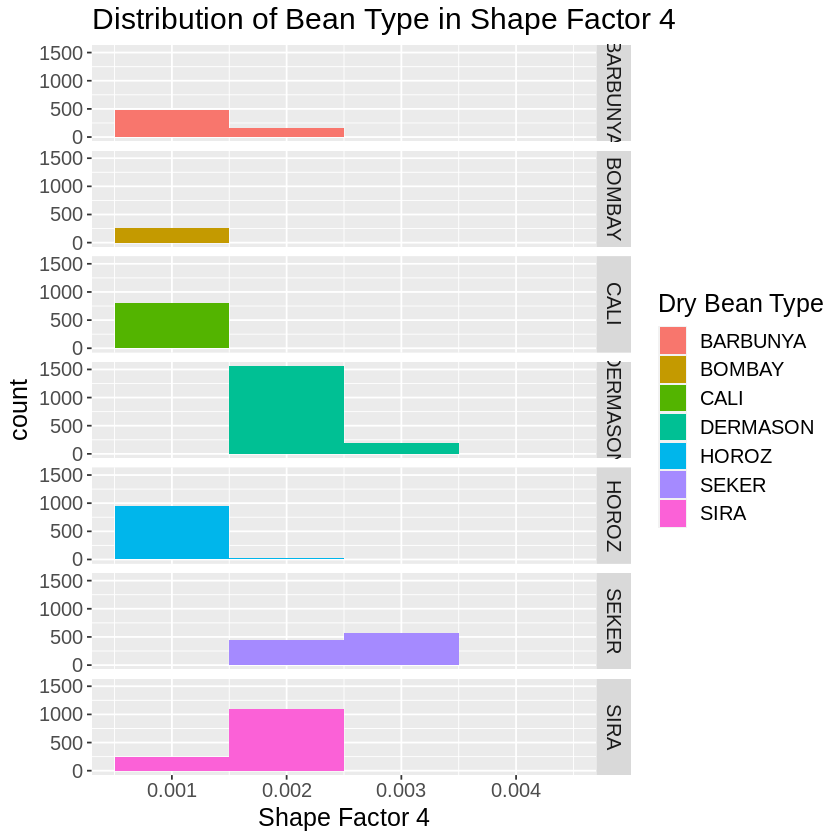

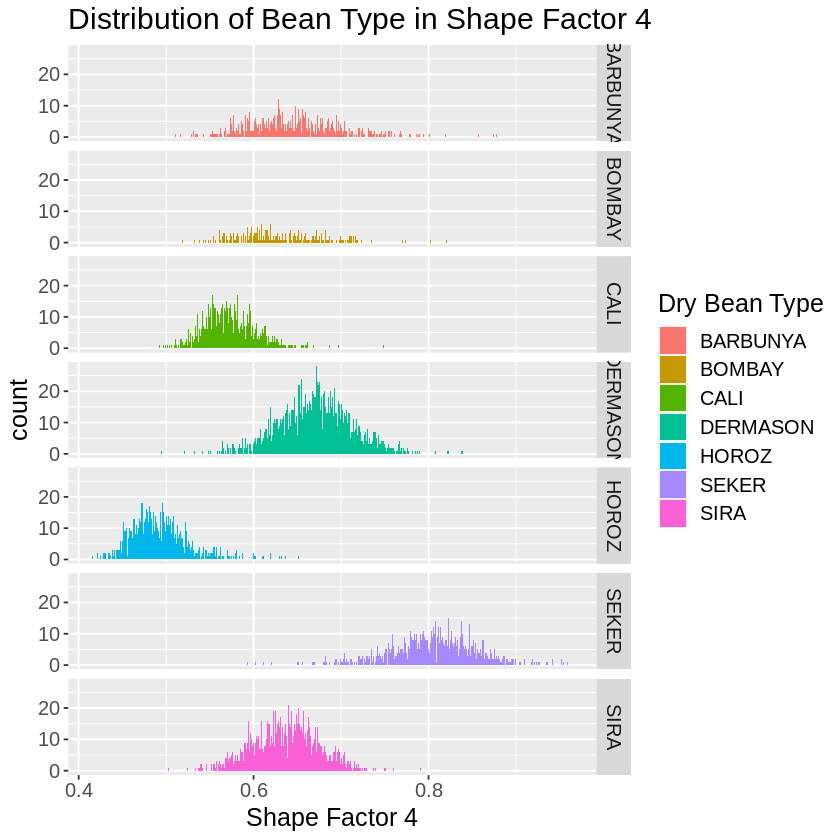

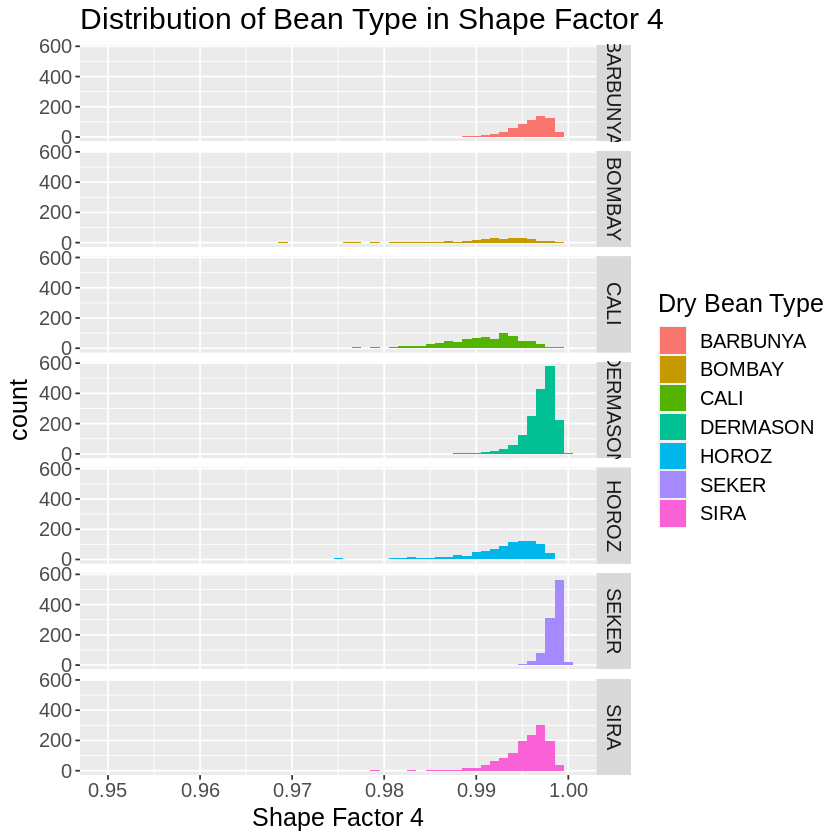

In [5]:

        
bean_area <- bean_train |> 
        ggplot(aes(x= Area, fill = Class))+
        geom_histogram(position= "identity", binwidth = 0.019) +
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))+
        labs(x = "Area", 
           fill = "Dry Bean Type") +
  scale_x_log10(labels = label_comma()) +
  ggtitle("Distribution of Bean Type in Area")

bean_perimeter <- bean_train |> 
        ggplot(aes(x= Perimeter, fill = Class))+
        geom_histogram(position= "identity", binwidth = 20) +
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))+
        labs(x = "Perimeter", 
           fill = "Dry Bean Type") +
  ggtitle("Distribution of Bean Type in Perimeter")

bean_majoraxislength <- bean_train |> 
        ggplot(aes(x= MajorAxisLength, fill = Class))+
        geom_histogram(position= "identity", binwidth = 20) +
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))+
        labs(x = "Major Axis Length", 
           fill = "Dry Bean Type") +
  ggtitle("Distribution of Bean Type in Major Axis Length")

bean_minoraxislength <- bean_train |> 
        ggplot(aes(x= MinorAxisLength, fill = Class))+
        geom_histogram(position= "identity", binwidth = 20) +
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))+
        labs(x = "Minor Axis Length", 
           fill = "Dry Bean Type") +
  ggtitle("Distribution of Bean Type in Minor Axis Length")

bean_aspectration <- bean_train |> 
        ggplot(aes(x= AspectRation, fill = Class))+
        geom_histogram(position= "identity", binwidth = 0.009)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))  +
    labs(x = "Aspect Ratio", 
           fill = "Dry Bean Type")+
  ggtitle("Distribution of Bean Type in Aspect Ratio")

bean_eccentricity <- bean_train |> 
        ggplot(aes(x= Eccentricity, fill = Class))+
        geom_histogram(position= "identity", binwidth = 0.009)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))+
    labs(x = "Eccentricity", 
           fill = "Dry Bean Type")+
  ggtitle("Distribution of Bean Type in Eccentricity")

bean_convexarea <- bean_train |> 
        ggplot(aes(x= ConvexArea, fill = Class))+
        geom_histogram(position= "identity", binwidth = 0.1)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))+
    labs(x = "Convex Area", 
           fill = "Dry Bean Type")+
 scale_x_log10(labels = label_comma())+
  ggtitle("Distribution of Bean Type in Convex Area")

bean_equivdiameter <- bean_train |> 
        ggplot(aes(x= EquivDiameter, fill = Class))+
        geom_histogram(position= "identity", binwidth = 20)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))+
    labs(x = "Equivalent Diameter", 
           fill = "Dry Bean Type")+
  ggtitle("Distribution of Bean Type in Equivalent Diameter")

bean_extent <- bean_train |> 
        ggplot(aes(x= Extent, fill = Class))+
        geom_histogram(position= "identity", binwidth = 0.009)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))+
    labs(x = "Extent", 
           fill = "Dry Bean Type")+
  ggtitle("Distribution of Bean Type in Extent")

bean_solidity <- bean_train |> 
        ggplot(aes(x= Solidity, fill = Class))+
        geom_histogram(position= "identity",binwidth = 0.001)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))+
    labs(x = "Solidity", 
           fill = "Dry Bean Type")+
  ggtitle("Distribution of Bean Type in Solidity")

bean_roundness <- bean_train |> 
        ggplot(aes(x= roundness, fill = Class))+
        geom_histogram(position= "identity", binwidth = 0.009)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))+
    labs(x = "Roundness", 
           fill = "Dry Bean Type")+
  ggtitle("Distribution of Bean Type in Roundness")

bean_compactness <- bean_train |> 
        ggplot(aes(x= Compactness, fill = Class))+
        geom_histogram(position= "identity", binwidth = 0.009)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))+
    labs(x = "Roundness", 
           fill = "Dry Bean Type")+
  ggtitle("Distribution of Bean Type in Compactness")

bean_shapefactor1 <- bean_train |> 
        ggplot(aes(x= ShapeFactor1, fill = Class)) +
        geom_histogram(position= "identity", binwidth = 0.001)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))+
        labs(x = "Shape Factor 4", 
           fill = "Dry Bean Type") +
  ggtitle("Distribution of Bean Type in Shape Factor 4")
        
bean_shapefactor2 <- bean_train |> 
        ggplot(aes(x= ShapeFactor2, fill = Class)) +
        geom_histogram(position= "identity", binwidth = 0.001)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))+
        labs(x = "Shape Factor 4", 
           fill = "Dry Bean Type") +
  ggtitle("Distribution of Bean Type in Shape Factor 4")
        
bean_shapefactor3 <- bean_train |> 
        ggplot(aes(x= ShapeFactor3, fill = Class)) +
        geom_histogram(position= "identity", binwidth = 0.001)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))+
        labs(x = "Shape Factor 4", 
           fill = "Dry Bean Type") +
  ggtitle("Distribution of Bean Type in Shape Factor 4")
        
bean_shapefactor4 <- bean_train |> 
        ggplot(aes(x= ShapeFactor4, fill = Class)) +
        geom_histogram(position= "identity", binwidth = 0.001)+
        facet_grid(rows = vars(Class))+
     theme(text = element_text(size = 15))+
        labs(x = "Shape Factor 4", 
           fill = "Dry Bean Type") +
  ggtitle("Distribution of Bean Type in Shape Factor 4")
        
bean_area
bean_perimeter 
bean_majoraxislength
bean_minoraxislength
bean_aspectration
bean_eccentricity
bean_convexarea
bean_equivdiameter
bean_extent
bean_solidity
bean_roundness
bean_compactness
bean_shapefactor1
bean_shapefactor2
bean_shapefactor3
bean_shapefactor4



# We also specify position = "identity" in geom_histogram to ensure the histograms for each experiment will be
# overlaid side-by-side, instead of stacked bars

### Explanation of graphs

In [6]:
### Add the eplanation here and then convert into a markdown cell

In [7]:
# Train data after the selected predictors
bean_train <- bean_train|>
                        select(Perimeter, AspectRation, Eccentricity, EquivDiameter, roundness, Compactness, Class)
# Generate summary Statistics of data set. 
bean_train$Class <- factor(bean_train$Class, levels=c("BARBUNYA", "BOMBAY", "CALI", "DERMASON", "HOROZ", "SEKER", "SIRA"))
summary(bean_train )

############## Tableone package ###############

CreateTableOne(data=bean_train) # descriptive table for the entire dataset
table_detail <- CreateTableOne(data=bean_train)
summary(table_detail)

   Perimeter       AspectRation    Eccentricity    EquivDiameter  
 Min.   : 530.8   Min.   :1.036   Min.   :0.2628   Min.   :162.7  
 1st Qu.: 702.8   1st Qu.:1.434   1st Qu.:0.7169   1st Qu.:214.7  
 Median : 794.0   Median :1.552   Median :0.7647   Median :238.1  
 Mean   : 855.0   Mean   :1.584   Mean   :0.7513   Mean   :253.0  
 3rd Qu.: 977.8   3rd Qu.:1.710   3rd Qu.:0.8111   3rd Qu.:279.9  
 Max.   :1895.9   Max.   :2.389   Max.   :0.9082   Max.   :562.4  
                                                                  
   roundness       Compactness          Class     
 Min.   :0.5568   Min.   :0.6454   BARBUNYA: 648  
 1st Qu.:0.8329   1st Qu.:0.7617   BOMBAY  : 266  
 Median :0.8836   Median :0.8011   CALI    : 814  
 Mean   :0.8735   Mean   :0.7996   DERMASON:1762  
 3rd Qu.:0.9166   3rd Qu.:0.8336   HOROZ   : 963  
 Max.   :0.9879   Max.   :0.9816   SEKER   :1012  
                                   SIRA    :1339  

                           
                            Overall        
  n                           6804         
  Perimeter (mean (SD))     855.02 (214.44)
  AspectRation (mean (SD))    1.58 (0.25)  
  Eccentricity (mean (SD))    0.75 (0.09)  
  EquivDiameter (mean (SD)) 253.03 (59.26) 
  roundness (mean (SD))       0.87 (0.06)  
  Compactness (mean (SD))     0.80 (0.06)  
  Class (%)                                
     BARBUNYA                  648 ( 9.5)  
     BOMBAY                    266 ( 3.9)  
     CALI                      814 (12.0)  
     DERMASON                 1762 (25.9)  
     HOROZ                     963 (14.2)  
     SEKER                    1012 (14.9)  
     SIRA                     1339 (19.7)  


     ### Summary of continuous variables ###

strata: Overall
                 n miss p.miss  mean    sd median   p25   p75   min   max  skew
Perimeter     6804    0      0 855.0 2e+02  794.0 702.8 977.8 530.8 2e+03  1.62
AspectRation  6804    0      0   1.6 2e-01    1.6   1.4   1.7   1.0 2e+00  0.56
Eccentricity  6804    0      0   0.8 9e-02    0.8   0.7   0.8   0.3 9e-01 -1.08
EquivDiameter 6804    0      0 253.0 6e+01  238.1 214.7 279.9 162.7 6e+02  1.94
roundness     6804    0      0   0.9 6e-02    0.9   0.8   0.9   0.6 1e+00 -0.59
Compactness   6804    0      0   0.8 6e-02    0.8   0.8   0.8   0.6 1e+00  0.05
               kurt
Perimeter      3.50
AspectRation   0.09
Eccentricity   1.44
EquivDiameter  5.09
roundness      0.16
Compactness   -0.22


     ### Summary of categorical variables ### 

strata: Overall
   var    n miss p.miss    level freq percent cum.percent
 Class 6804    0    0.0 BARBUNYA  648     9.5         9.5
                          BOMBAY  266     3.9        13

### Explanation of summary table


### Forward selection
We are using forward selection to determine the best model once we have reduced the predictor number to seven through preliminary analysis. This is bacause forward selection code would not run with all 16 predictors on Juypter.   

In [ ]:
# # select all columns (possible predictors) except Class
# names <- colnames(bean_train |> select (-Class))

# # Make model formula for all predictors
# model_formula <- paste("Class", "~", paste(names, collapse="+"))
# model_formula 

# # create an empty tibble to store the results
# accuracies <- tibble(size = integer(), 
#                      model_string = character(), 
#                      accuracy = numeric())

# # create a model specification
# knn_spec <- nearest_neighbor(weight_func = "rectangular", 
#                              neighbors = tune()) |>
#      set_engine("kknn") |>
#      set_mode("classification")

# # create a 5-fold cross-validation object
# BeanData_vfold <- vfold_cv(bean_train, v = 5, strata = Class)

# # store the total number of predictors
# n_total <- length(names)

# # stores selected predictors
# selected <- c()

In [ ]:
# # for every size from 1 to the total number of predictors
# for (i in 1:n_total) {
#     # for every predictor still not added yet
#     accs <- list()
#     models <- list()
#     for (j in 1:length(names)) {
#         # create a model string for this combination of predictors
#         preds_new <- c(selected, names[[j]])
#         model_string <- paste("Class", "~", paste(preds_new, collapse="+"))

#         # create a recipe from the model string
#         BeanData_recipe <- recipe(as.formula(model_string), 
#                                 data = bean_train) |>
#                           step_scale(all_predictors()) |>
#                           step_center(all_predictors())

#         # tune the KNN classifier with these predictors, 
#         # and collect the accuracy for the best K
#         acc <- workflow() |>
#           add_recipe( BeanData_recipe ) |>
#           add_model(knn_spec) |>
#           tune_grid(resamples = BeanData_vfold, grid = 10) |>
#           collect_metrics() |>
#           filter(.metric == "accuracy") |>
#           summarize(mx = max(mean))
#         acc <- acc$mx |> unlist()

#         # add this result to the dataframe
#         accs[[j]] <- acc
#         models[[j]] <- model_string
#     }
#     jstar <- which.max(unlist(accs))
#     accuracies <- accuracies |> 
#       add_row(size = i, 
#               model_string = models[[jstar]], 
#               accuracy = accs[[jstar]])
#     selected <- c(selected, names[[jstar]])
#     names <- names[-jstar]
# }
# accuracies

### Results of forward selection
The model with the highest accuracy has Perimeter, Compactness, roundness, Eccentricity, EquivDiameter, AspectRation, and ConvexArea as the predictors. The accuracy for this model is 91.5%. These results align with what we derived from our preliminary analysis. Hence, we are confident that the k-nearest model using these seven predictors will accurately classify the Class of a new seed 91.5% of the time. 

In [ ]:
#THIS CODE IS FOR FINDING THE OPTIMAL VALUE OF K FOR OUR SELECTED MODEL

set.seed(2020) # DO NOT REMOVE
# standarization recipe

bean_recipe <- recipe(Class ~., data = bean_train) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

# model specification
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
      set_mode("classification")

# cross validation

bean_vfold <- vfold_cv(bean_train, v = 5, strata = Class)

# Assemble into workflow
knn_results <- workflow() |>
       add_recipe(bean_recipe) |>
       add_model(knn_tune) |>
       tune_grid(resamples = bean_vfold, grid = 10) |>
       collect_metrics()

knn_results

In [ ]:

# find best value of number of K
accuracies <- knn_results |> 
       filter(.metric=="accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
accuracies
accuracy_versus_k

# the highest accuracy is 91.12 and it is found at K=12
highest_accuracy <- accuracies|> select(neighbors, mean)|> arrange(desc(mean))
highest_accuracy

###### 